## Call peaks for the GITR locus screen in mouse T cells using aggrDESeq2 approach, then compare peak calls across methods

### First, generate 100bp bin mapping for gRNAs

First need to adjust the gRNA coordinates to retrieve the PAM coordinates, write .bed file, the intersect with 100bp bins of mouse chr4 assuming a +/-150bp window of effect for KRAB perturbation.

#### Start in `R`

#### Load libraries for data processing

In [3]:
suppressPackageStartupMessages(library(tidyverse))

#### Load sgRNA content

In [4]:
guidescan <- read.delim("figure4_tcells/screen_data/guideScan_output.spec_score_over_0_2.noTTTTnoGGGGG.original.uniqueName.5bp_max_overlap.accessibilityScore_ranked_in_peaks.final.v2.txt",
                   header = TRUE)

head(guidescan,n=1)
dim(guidescan)

,chromosome,target.site.start.coordinate,target.site.end.coordinate,gRNA,cutting.efficiency.score,cutting.specificity.score,strand,offtargets.sum,offtargets.summary,annotation,gRNA.label,accessibility_cpm,peak,rank_in_peak
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
1,chr4,156026280,156026302,GGCCTGAAGCCCAGTCTGAG,56,0.2401473,+,22,2:1|3:21,*,peak_10__66,6.566831,peak_10_,1


[1] 404  14

In [5]:
guidescan %>%
filter(cutting.specificity.score < 0.2)

chromosome,target.site.start.coordinate,target.site.end.coordinate,gRNA,cutting.efficiency.score,cutting.specificity.score,strand,offtargets.sum,offtargets.summary,annotation,gRNA.label,accessibility_cpm,peak,rank_in_peak
<chr>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>


In [24]:
guidescan %>%
mutate(chr = chromosome,
       start = target.site.start.coordinate,
       end = target.site.end.coordinate,
       protospacer = gRNA,
       grna = paste0(chr,":",start,"-",end,"_",strand,"_",protospacer)) %>%
select(grna, protospacer, chr, start, end, strand) %>%
distinct() %>%
mutate(length_seq = nchar(protospacer),
       length_coords = end - start,
       true_start = ifelse(strand == "+", start, start + 3),
       true_end = ifelse(strand == "+", end - 3, end),
       cutsite_chr = chr,
       cutsite_start = ifelse(strand == "+", true_end - 3, true_start + 3),
       cutsite_end = ifelse(strand == "+", true_end, true_start),
       new_chr = chr,
       new_start = ifelse(cutsite_start < cutsite_end, cutsite_start, cutsite_end),
       new_end = ifelse(cutsite_start < cutsite_end, cutsite_end, cutsite_start)
       ) %>%
select(new_chr, new_start, new_end, grna) %>%
distinct() %>%
write.table("figure4_tcells/screen_data/GITR_grna_cutsite_coords.bed", 
            col.names=F, row.names=F, quote=F, sep="\t")

All guides are 20bp --> use +/-3.

GGCCTGAAGCCCAGTCTGAG chr4   +   156026280 156026299     20
ACTCTCCTCCTTGCCTTACC	chr4   -   156026537 156026556     20

#### Switch to `python`

#### Load chromosome sizes (use as input to make windows)

In [2]:
%%bash

grep -P 'chr4' annotations/mm10.chromSizes.noalts.txt > annotations/mm10.chr4size.bed
head annotations/mm10.chr4size.bed

chr4	156508116


#### Make 100bp bins along chr4, then intersect those bins with the gRNAs assuming a +/- 150bp window of effect for KRAB

In [5]:
%%bash

module load bedtools2

bedtools makewindows -g annotations/mm10.chr4size.bed -w 100 -s 100 |\
bedtools window \
-a figure4_tcells/screen_data/GITR_grna_cutsite_coords.bed \
-b stdin -w 150 \
> figure4_tcells/screen_data/GITR_grna_cutsite_coords.krab.100step.txt

head -n 1 figure4_tcells/screen_data/GITR_grna_cutsite_coords.krab.100step.txt
wc -l figure4_tcells/screen_data/GITR_grna_cutsite_coords.krab.100step.txt

chr4	156026296	156026299	chr4:156026280-156026302_+_GGCCTGAAGCCCAGTCTGAG	chr4	156026100	156026200
1623 figure4_tcells/screen_data/GITR_grna_cutsite_coords.krab.100step.txt


### Now, start processing gRNA counts and run DESeq2 in `R`

### Load libraries for data processing

In [1]:
suppressPackageStartupMessages(library(tidyverse))

### Prepare input data

#### Load sgRNA content for T cell library

In [2]:
guidescan <- read.delim("figure4_tcells/screen_data/guideScan_output.spec_score_over_0_2.noTTTTnoGGGGG.original.uniqueName.5bp_max_overlap.accessibilityScore_ranked_in_peaks.final.v2.txt",
                   header = TRUE)

head(guidescan,n=1)
dim(guidescan)

,chromosome,target.site.start.coordinate,target.site.end.coordinate,gRNA,cutting.efficiency.score,cutting.specificity.score,strand,offtargets.sum,offtargets.summary,annotation,gRNA.label,accessibility_cpm,peak,rank_in_peak
,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>
1,chr4,156026280,156026302,GGCCTGAAGCCCAGTCTGAG,56,0.2401473,+,22,2:1|3:21,*,peak_10__66,6.566831,peak_10_,1


[1] 404  14

In [3]:
guidescan %>%
filter(cutting.specificity.score < 0.2)

chromosome,target.site.start.coordinate,target.site.end.coordinate,gRNA,cutting.efficiency.score,cutting.specificity.score,strand,offtargets.sum,offtargets.summary,annotation,gRNA.label,accessibility_cpm,peak,rank_in_peak
<chr>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>


#### Load counts 

In [4]:
guide_counts <- read.delim("figure4_tcells/screen_data/220304_TG2_GITR_KRAB_Output_CountTable.txt", header = TRUE)
head(guide_counts,n=1)
dim(guide_counts)

,chr,start,end,strand,locus,guideID,sequence,TG2.GITR.Hi.rep1,TG2.GITR.Hi.rep2,TG2.GITR.Hi.rep3,TG2.GITR.Hi.rep4,TG2.GITR.Lo.rep1,TG2.GITR.Lo.rep2,TG2.GITR.Lo.rep3,TG2.GITR.Lo.rep4
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr4,156026280,156026302,+,peak_10,66,GGCCTGAAGCCCAGTCTGAG,71,78,86,81,1055,993,1426,840


[1] 444  15

#### Combine replicates into one df, then filter out low-specificity sgRNAs (guidescan < 0.2 and 'NA')

In [5]:
df <- 
guide_counts %>%
mutate(grna = paste0(chr,":",start,"-",end,"_",strand,"_",sequence),
       high_rep1 = TG2.GITR.Hi.rep1,
       high_rep2 = TG2.GITR.Hi.rep2,
       high_rep3 = TG2.GITR.Hi.rep3,
       high_rep4 = TG2.GITR.Hi.rep4,
       low_rep1 = TG2.GITR.Lo.rep1,
       low_rep2 = TG2.GITR.Lo.rep2,
       low_rep3 = TG2.GITR.Lo.rep3,
       low_rep4 = TG2.GITR.Lo.rep4) %>%
select(grna:low_rep4)

head(df,n=1)
dim(df) 

,grna,high_rep1,high_rep2,high_rep3,high_rep4,low_rep1,low_rep2,low_rep3,low_rep4
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr4:156026280-156026302_+_GGCCTGAAGCCCAGTCTGAG,71,78,86,81,1055,993,1426,840


[1] 444   9

#### Check for duplicates (sgRNAs with >1 value for count in at least one replicate)

In [6]:
df[duplicated(df$grna),]

grna,high_rep1,high_rep2,high_rep3,high_rep4,low_rep1,low_rep2,low_rep3,low_rep4
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>


#### Generate metadata

In [7]:
samples <- colnames(df %>% select(-grna))
meta <- data.frame(sample = samples, group = c("high","high","high","high","low","low","low","low"))

meta

sample,group
<chr>,<chr>
high_rep1,high
high_rep2,high
high_rep3,high
high_rep4,high
low_rep1,low
low_rep2,low
low_rep3,low
low_rep4,low


#### Prepare counts and metadata for summarized experiment

In [8]:
df.clean <- as.matrix(df %>% select(-grna))
row.names(df.clean) <- df$grna
coldata <- meta[,c("sample","group")]

### DESeq2

In [9]:
suppressPackageStartupMessages(library(DESeq2))

#### Make DESeq2 summarized experiment

In [10]:
se <- DESeqDataSetFromMatrix(
  countData = df.clean,
  colData = coldata,
  design = ~ group
)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


#### Run DESeq2

In [11]:
dds <- DESeq(se)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



#### Generate results object

In [12]:
res <- results(dds, contrast = c("group","high","low"))

#### DESeq2 results

In [13]:
summary(res)


out of 444 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 30, 6.8%
LFC < 0 (down)     : 70, 16%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 77)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



#### Add grna and locus to results

In [34]:
res_labeled <- as.data.frame(res, row.names = NULL)
res_labeled$grna <- rownames(res)

res_labeled <- res_labeled %>% left_join(guide_counts %>%
                                         mutate(grna = paste0(chr,":",start,"-",end,"_",strand,"_",sequence)) %>%
                                         select(grna, locus) %>%
                                         distinct(),
                                         by = "grna")

head(res_labeled,n=1)
dim(res_labeled)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,grna,locus
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,598.3767,-3.917804,0.1653469,-23.69446,4.112898e-124,9.130634e-122,chr4:156026280-156026302_+_GGCCTGAAGCCCAGTCTGAG,peak_10


[1] 444   8

#### Write .tsv file with results

In [35]:
write_tsv(res_labeled, "figure4_tcells/deseq2_results/high_vs_low_deseq2_results.tsv", col_names = TRUE)

### Visualization and QC

In [16]:
suppressPackageStartupMessages(library(vsn))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(pheatmap))

#### Extract transformed values

In [17]:
vsd <- vst(dds, blind = FALSE, nsub=nrow(dds))

In [18]:
rld <- rlog(dds, blind = FALSE)

#### Log-transform, scale-shift

In [19]:
ntd <- normTransform(dds) # this gives log2(n+1)

#### Variance plots with different types of transformations/scaling

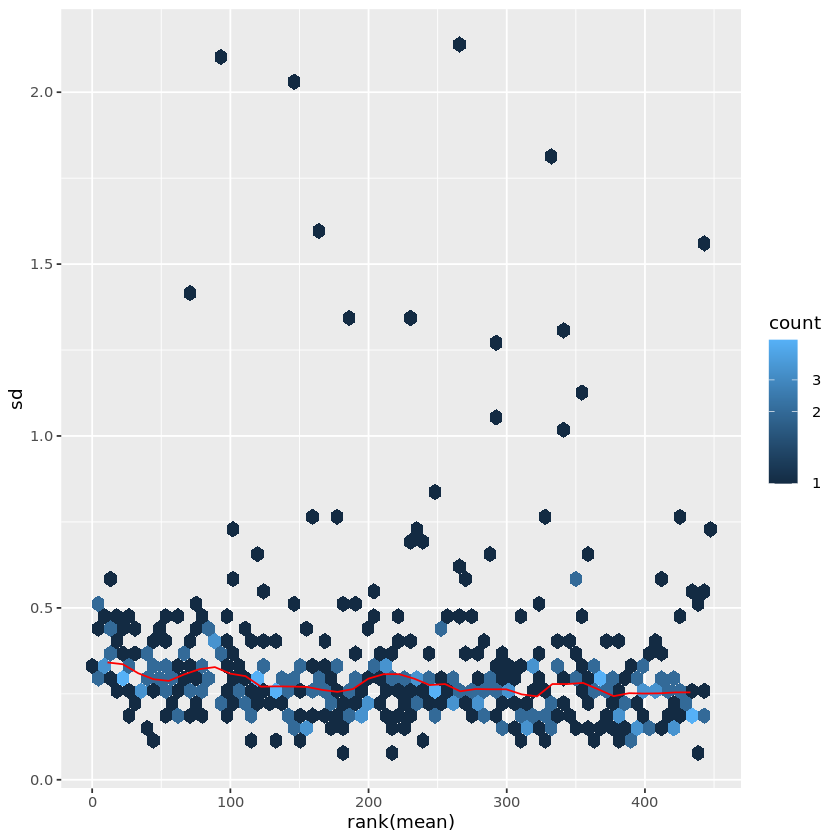

In [20]:
meanSdPlot(assay(ntd))

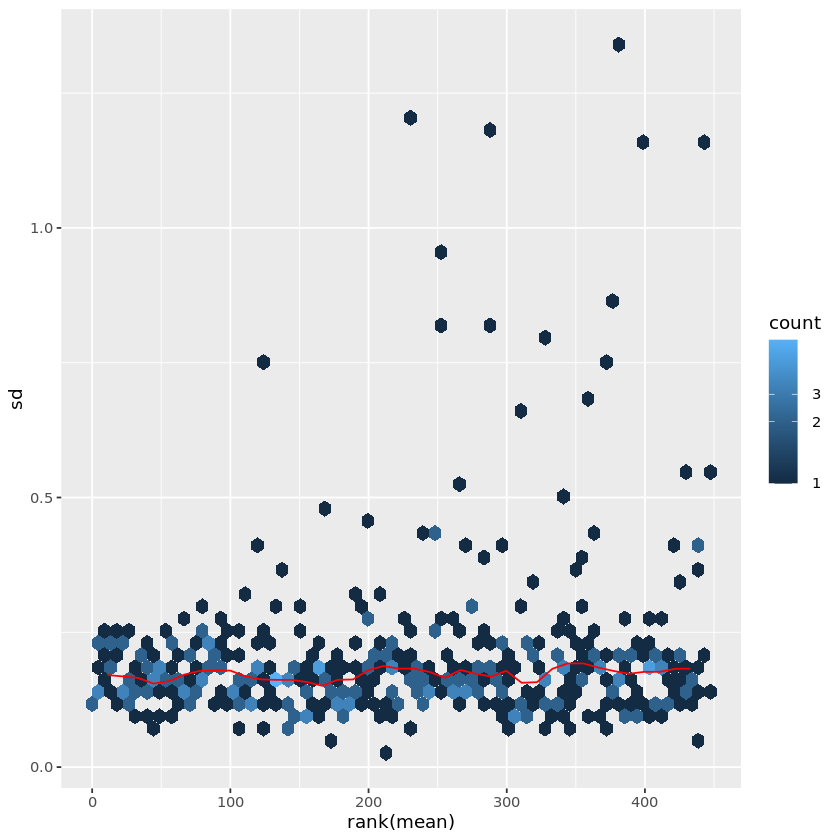

In [21]:
meanSdPlot(assay(vsd))

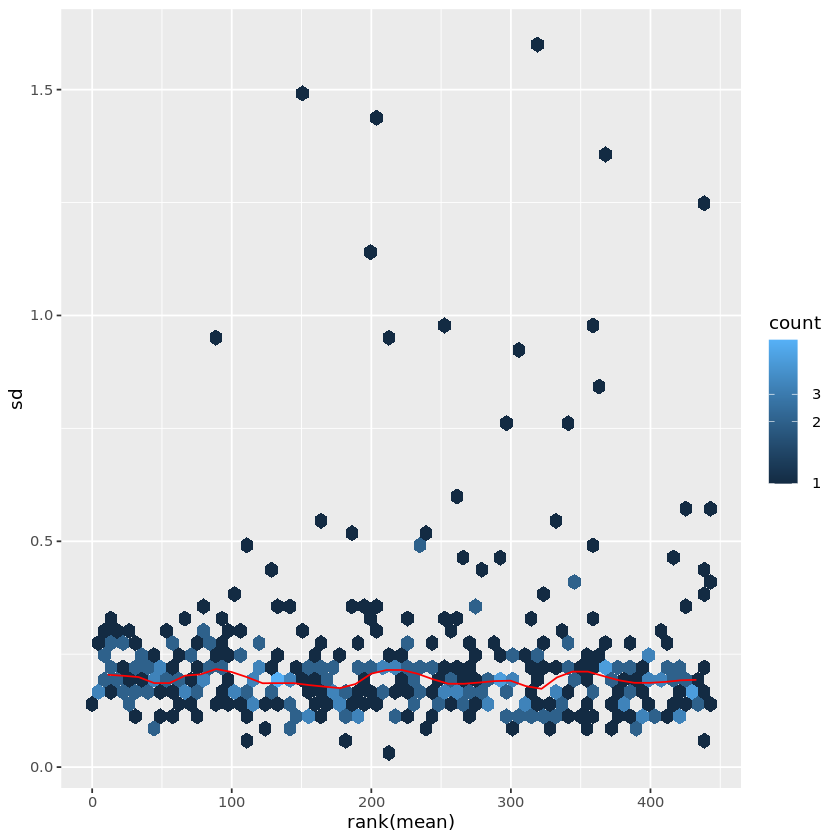

In [22]:
meanSdPlot(assay(rld))

#### PCA

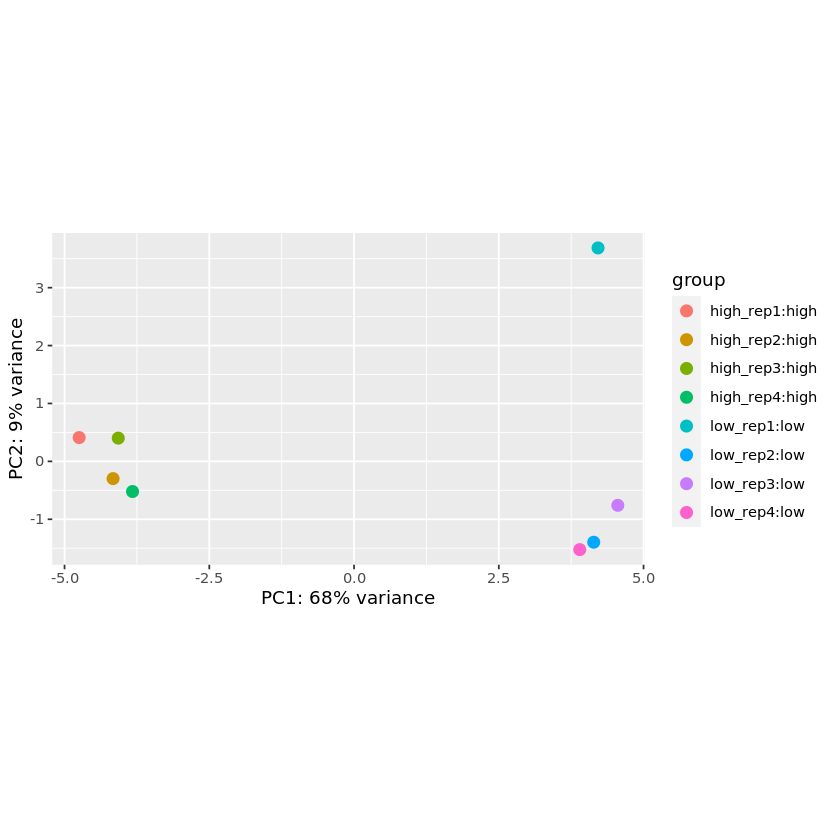

In [23]:
plotPCA(vsd, intgroup=c("sample", "group"))

#### Heatmap of sample-sample distance

In [24]:
sampleDists <- dist(t(assay(vsd)))

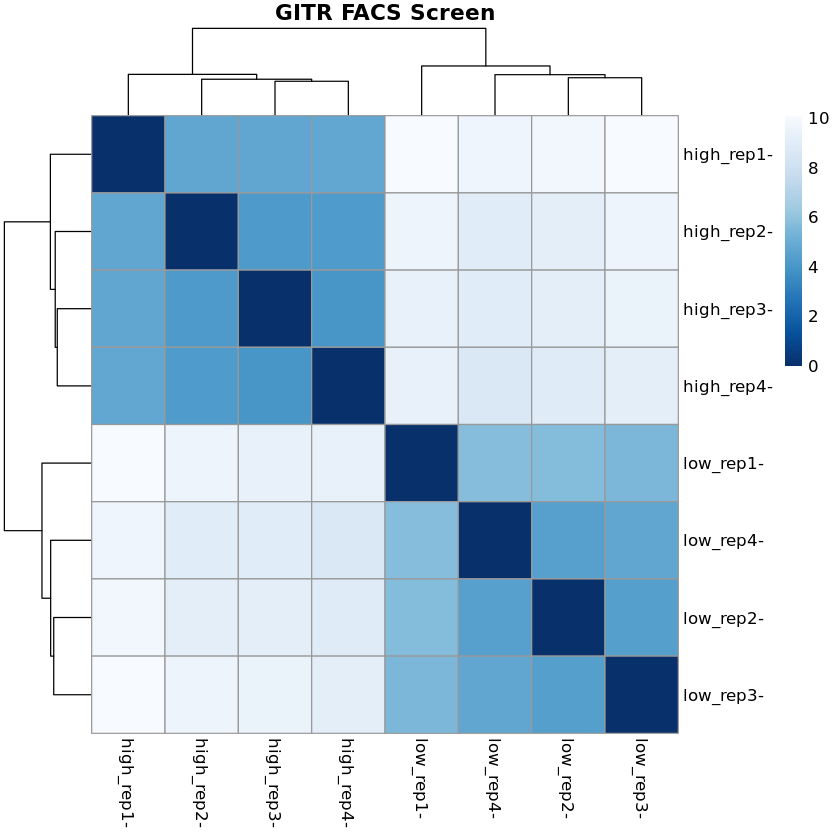

In [25]:
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(vsd$sample, vsd$type, sep="-")
colnames(sampleDistMatrix) <- paste(vsd$sample, vsd$type, sep="-") # change to 'NULL' to get rid of bottom labels
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors,
         main = "GITR FACS Screen")

### Aggregate sgRNA-level effects to call "peaks"

In [ ]:
suppressPackageStartupMessages(library(tidyverse))

#### Define fisher's method to aggregate p values
 - https://mikelove.wordpress.com/2012/03/12/combining-p-values-fishers-method-sum-of-p-values-binomial/
 - https://www.biostars.org/p/211307/

In [36]:
fishersMethod = function(x) pchisq(-2 * sum(log(x)),df=2*length(x),lower=FALSE)

#### Re-load results (if needed)

In [37]:
res_labeled <- read_tsv("figure4_tcells/deseq2_results/high_vs_low_deseq2_results.tsv", show_col_types = FALSE)
head(res_labeled,n=1)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,grna,locus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
598.3767,-3.917804,0.1653469,-23.69446,4.112898e-124,9.130634e-122,chr4:156026280-156026302_+_GGCCTGAAGCCCAGTCTGAG,peak_10


#### Load output of bedtools intersect 

Defines "bins" and which sgRNAs belong to each bin after adjusting for perturbation modality.

In [38]:
grna_int_bins <- read.delim("figure4_tcells/screen_data/GITR_grna_cutsite_coords.krab.100step.txt", 
                            header = FALSE, 
                            col.names = c("grna_chrom","grna_start","grna_end","grna","bin_chr","bin_start","bin_end")) %>%
mutate(bin = paste0(bin_chr,":",bin_start,"-",bin_end))

head(grna_int_bins,n=1)
dim(grna_int_bins)

,grna_chrom,grna_start,grna_end,grna,bin_chr,bin_start,bin_end,bin
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,chr4,156026296,156026299,chr4:156026280-156026302_+_GGCCTGAAGCCCAGTCTGAG,chr4,156026100,156026200,chr4:156026100-156026200


[1] 1623    8

#### Subset DESeq2 results for only targeting sgRNAs

Want to remove the promoter positive controls and non-targeting negative controls prior to aggregating gRNA p-values and logFC. If a promoter positive control was included in a bin calculation, it could skew the result towards being more significant (assuming it worked as intended). The negative controls do not have coordinates so they will not have a bin assignment.

In [39]:
target_grna <- res_labeled %>% filter(grepl("peak", locus))

head(target_grna,n=1)
dim(target_grna)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,grna,locus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
598.3767,-3.917804,0.1653469,-23.69446,4.112898e-124,9.130634e-122,chr4:156026280-156026302_+_GGCCTGAAGCCCAGTCTGAG,peak_10


[1] 386   8

#### Number of significant bins (CREs)

In [51]:
target_grna %>%
left_join(grna_int_bins, by = "grna") %>%
group_by(bin) %>%
summarize(n = n(),
          fisher = fishersMethod(pvalue), 
          mean_logfc = mean(abs(log2FoldChange)),
          max_logfc = max(abs(log2FoldChange)),
          bin_mid = (bin_end+bin_start)/2) %>%
select(bin, bin_mid, mean_logfc, max_logfc, fisher, n) %>%
ungroup() %>%
distinct() %>%
mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
mutate(sep = bin,
       sig = -log10(fdr)) %>%
separate(sep, into = c("chrom","start","end")) %>%
select(chrom, start, end, bin:sig) %>%
filter(fdr < 0.1) %>%
select(bin) %>%
distinct() %>%
pull() %>% length()

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


[1] 112

#### Filter for FDR < 0.1, write .bed files

In [52]:
target_grna %>%
left_join(grna_int_bins, by = "grna") %>%
group_by(bin) %>%
summarize(n = n(),
          fisher = fishersMethod(pvalue), 
          mean_logfc = mean(abs(log2FoldChange)),
          max_logfc = max(abs(log2FoldChange)),
          bin_mid = (bin_end+bin_start)/2) %>%
select(bin, bin_mid, mean_logfc, max_logfc, fisher, n) %>%
ungroup() %>%
distinct() %>%
mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
mutate(sep = bin,
       sig = -log10(fdr)) %>%
separate(sep, into = c("chrom","start","end")) %>%
select(chrom, start, end, bin:sig) %>%
filter(fdr < 0.1) %>%
mutate(strand = ".") %>%
select(chrom:bin, sig, strand) %>%
write.table("figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.adjp.mm10.bed", 
            col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")


`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


In [53]:
target_grna %>%
left_join(grna_int_bins, by = "grna") %>%
group_by(bin) %>%
summarize(n = n(),
          fisher = fishersMethod(pvalue), 
          mean_logfc = mean(abs(log2FoldChange)),
          max_logfc = max(abs(log2FoldChange)),
          bin_mid = (bin_end+bin_start)/2) %>%
select(bin, bin_mid, mean_logfc, max_logfc, fisher, n) %>%
ungroup() %>%
distinct() %>%
mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
mutate(sep = bin,
       sig = -log10(fdr)) %>%
separate(sep, into = c("chrom","start","end")) %>%
select(chrom, start, end, bin:sig) %>%
filter(fdr < 0.1) %>%
mutate(strand = ".") %>%
select(chrom:bin, mean_logfc, strand) %>%
write.table("figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.abslog2fc.mm10.bed", 
            col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")


`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


In [54]:
target_grna %>%
left_join(grna_int_bins, by = "grna") %>%
group_by(bin) %>%
summarize(n = n(),
          fisher = fishersMethod(pvalue), 
          mean_logfc = mean(abs(log2FoldChange)),
          max_logfc = max(abs(log2FoldChange)),
          bin_mid = (bin_end+bin_start)/2) %>%
select(bin, bin_mid, mean_logfc, max_logfc, fisher, n) %>%
ungroup() %>%
distinct() %>%
mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
mutate(sep = bin,
       sig = -log10(fdr)) %>%
separate(sep, into = c("chrom","start","end")) %>%
select(chrom, start, end, bin:sig) %>%
filter(fdr < 0.1) %>%
mutate(strand = ".") %>%
select(chrom:bin, max_logfc, strand) %>%
write.table("figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.maxlog2fc.mm10.bed", 
            col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")
 

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


### Switch to `python` kernel

#### Sort bins and then merge adjacent bins to generate final peak calls for aggrDESeq2

In [2]:
%%bash
head -n 1 figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.adjp.mm10.bed
wc -l figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.adjp.mm10.bed

chr4	155991300	155991400	chr4:155991300-155991400	1.03732450825604	.
112 figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.adjp.mm10.bed


In [3]:
%%bash

sort -k1,1 -k2,2n figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.adjp.mm10.bed > figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.mm10.bed

head -n 1 figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.mm10.bed
wc -l figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.mm10.bed

chr4	155991300	155991400	chr4:155991300-155991400	1.03732450825604	.
112 figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.mm10.bed


In [4]:
%%bash
module load bedtools2

bedtools merge -d 1 -i figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.mm10.bed > figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.merge.mm10.bed

head -n 1 figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.merge.mm10.bed
wc -l figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.merge.mm10.bed

chr4	155991300	155992700
12 figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.merge.mm10.bed


#### Intersect peak calls from other methods. The output will be used to generate an upset plot comparing the results of each method.

In [1]:
%%bash
module load bedtools2

bedtools multiinter -header -i figure4_tcells/screen_data/gitr.perturbationregion.mm10.bed \
figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.merge.mm10.bed \
figure4_tcells/other_peakcalls/gitr_casa_peaks_mm10.bed \
> figure4_tcells/upset/gitr.peakcallerupset.txt

head figure4_tcells/upset/gitr.peakcallerupset.txt

chrom	start	end	num	list	figure4_tcells/screen_data/gitr.perturbationregion.mm10.bed	figure4_tcells/deseq2_peakcalls/gitr.deseq2.peakcalls.fdr01.sorted.merge.mm10.bed	figure4_tcells/other_peakcalls/gitr_casa_peaks_mm10.bed
chr4	155991300	155991530	1	2	0	1	0
chr4	155991530	155992700	2	1,2	1	1	0
chr4	155992700	155993100	1	1	1	0	0
chr4	155993100	155994100	2	1,2	1	1	0
chr4	155994100	156008500	1	1	1	0	0
chr4	156008500	156009300	2	1,2	1	1	0
chr4	156009300	156013600	1	1	1	0	0
chr4	156013600	156014700	2	1,2	1	1	0
chr4	156014700	156015400	1	1	1	0	0


### Change to `R`

### Load packages

In [3]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(UpSetR))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(ggplotify))

### Common region coordinates

In [4]:
commonregion <- read.delim("figure4_tcells/screen_data/gitr.perturbationregion.mm10.bed", header = FALSE,
                           col.names = c("chrom","start","end"))
head(commonregion)

,chrom,start,end
,<chr>,<int>,<int>
1,chr4,155991530,156035049


### Now, generate the upset plot

In [7]:
df <- read.delim("figure4_tcells/upset/gitr.peakcallerupset.txt", header = TRUE) %>%
  mutate(name = paste0(chrom,":",start,"-",end)) %>%
#   filter(chrom == commonregion$chrom) %>%
#   filter(start >= commonregion$start) %>%
#   filter(end <= commonregion$end) %>%
  rename(casa = `figure4_tcells.other_peakcalls.gitr_casa_peaks_mm10.bed`,
         deseq2 = `figure4_tcells.deseq2_peakcalls.gitr.deseq2.peakcalls.fdr01.sorted.merge.mm10.bed`,
         commonregion_coords = `figure4_tcells.screen_data.gitr.perturbationregion.mm10.bed`)

head(df,n=1)
dim(df)
colnames(df)

,chrom,start,end,num,list,commonregion_coords,deseq2,casa,name
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>
1,chr4,155991300,155991530,1,2,0,1,0,chr4:155991300-155991530


[1] 27  9

[1] "chrom"               "start"               "end"                
[4] "num"                 "list"                "commonregion_coords"
[7] "deseq2"              "casa"                "name"

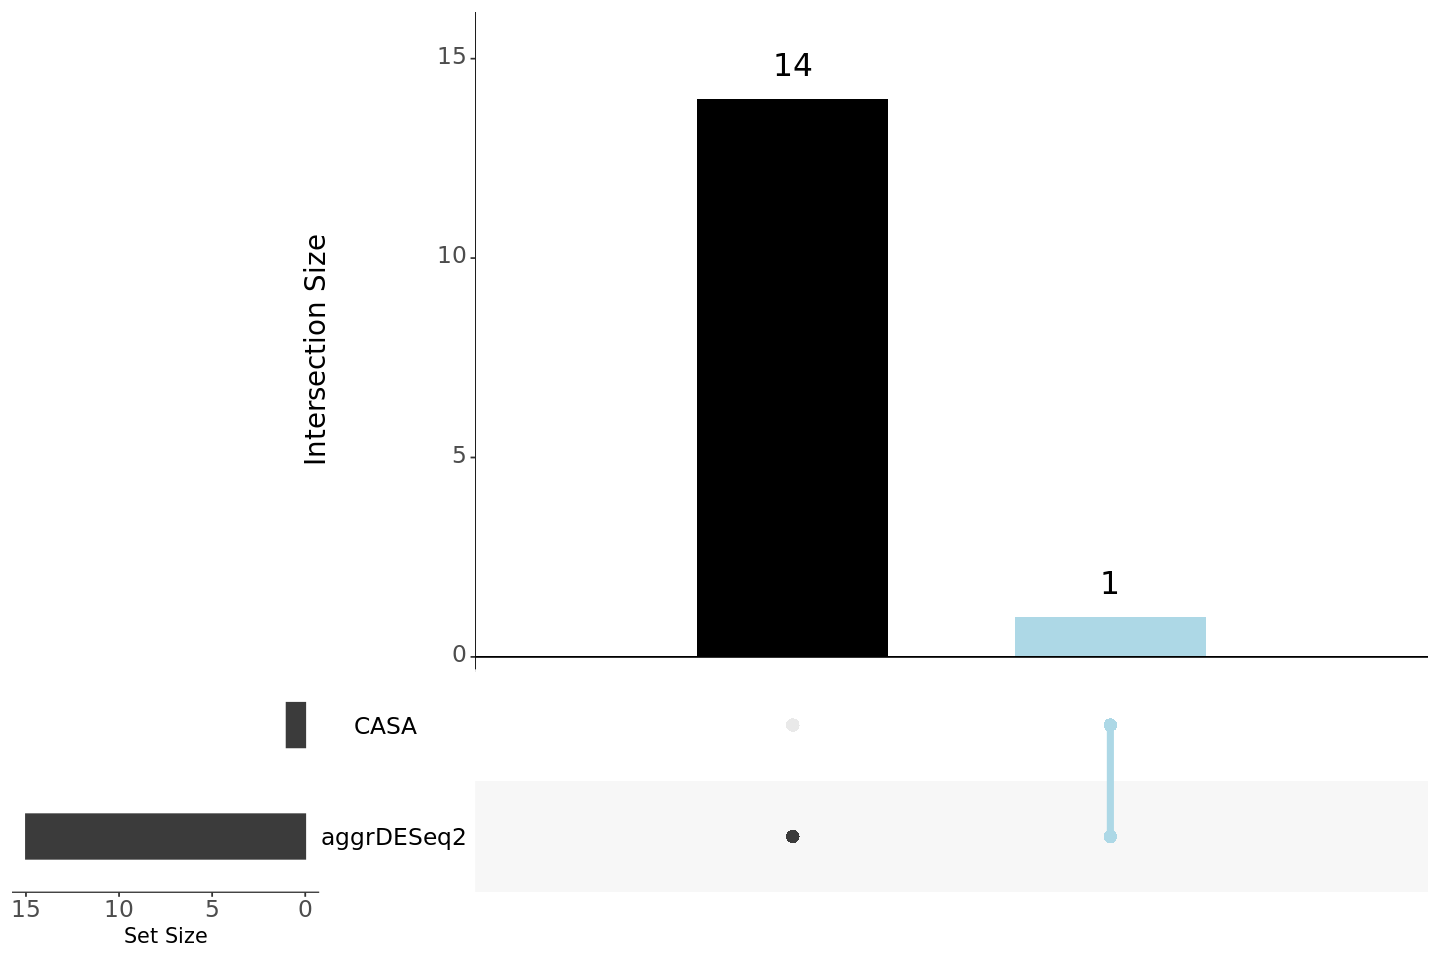

In [12]:
options(repr.plot.width = 12, repr.plot.height = 8)
screen1 <- df %>% filter(casa == 1) %>% select(name) %>% distinct() %>% pull()
screen2 <- df %>% filter(deseq2 == 1) %>% select(name) %>% distinct() %>% pull()

listInput <- list("CASA" = screen1, 
                  "aggrDESeq2" = screen2
                 )

p1 <- upset(fromList(listInput), 
      order.by = "freq",
      nsets = 3,
      queries = list(list(query = intersects, params = list("CASA","aggrDESeq2"), color = "lightblue", active = T)),
      # set_size.show = TRUE, ### these do not look good when added in R, add later in Illustrator
      # set_size.numbers_size = 5,
      point.size = 3.5, 
      line.size = 2, 
      mainbar.y.label = "Intersection Size", 
      sets.x.label = "Set Size", 
      main.bar.color = "black", 
      text.scale = c(2, 2, 1.5, 2, 2, 3) # intersection size title, intersection size tick labels, set size title, set size tick labels, set names, numbers above bars
      ) 

p1

In [14]:
pdf("figure4_tcells/plot_pdfs/gitr_upsetplot_aggrdeseq2_casa.pdf")
print(p1)
dev.off()

png 
  2

### Now, remove the most significant gRNA per bin, then re-aggregate sgRNA-level effects to call "peaks"

In [5]:
suppressPackageStartupMessages(library(tidyverse))

#### Define fisher's method to aggregate p values
 - https://mikelove.wordpress.com/2012/03/12/combining-p-values-fishers-method-sum-of-p-values-binomial/
 - https://www.biostars.org/p/211307/

In [6]:
fishersMethod = function(x) pchisq(-2 * sum(log(x)),df=2*length(x),lower=FALSE)

#### Re-load results (if needed)

In [7]:
res_labeled <- read_tsv("figure4_tcells/deseq2_results/high_vs_low_deseq2_results.tsv", show_col_types = FALSE)
head(res_labeled,n=1)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,grna,locus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
598.3767,-3.917804,0.1653469,-23.69446,4.112898e-124,9.130634e-122,chr4:156026280-156026302_+_GGCCTGAAGCCCAGTCTGAG,peak_10


#### Load output of bedtools intersect 

Defines "bins" and which sgRNAs belong to each bin after adjusting for perturbation modality.

In [8]:
grna_int_bins <- read.delim("figure4_tcells/screen_data/GITR_grna_cutsite_coords.krab.100step.txt", 
                            header = FALSE, 
                            col.names = c("grna_chrom","grna_start","grna_end","grna","bin_chr","bin_start","bin_end")) %>%
mutate(bin = paste0(bin_chr,":",bin_start,"-",bin_end))

head(grna_int_bins,n=1)
dim(grna_int_bins)

,grna_chrom,grna_start,grna_end,grna,bin_chr,bin_start,bin_end,bin
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,chr4,156026296,156026299,chr4:156026280-156026302_+_GGCCTGAAGCCCAGTCTGAG,chr4,156026100,156026200,chr4:156026100-156026200


[1] 1623    8

#### Subset DESeq2 results for only targeting sgRNAs

Want to remove the promoter positive controls and non-targeting negative controls prior to aggregating gRNA p-values and logFC. If a promoter positive control was included in a bin calculation, it could skew the result towards being more significant (assuming it worked as intended). The negative controls do not have coordinates so they will not have a bin assignment.

In [9]:
target_grna <- res_labeled %>% filter(grepl("peak", locus))

head(target_grna,n=1)
dim(target_grna)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,grna,locus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
598.3767,-3.917804,0.1653469,-23.69446,4.112898e-124,9.130634e-122,chr4:156026280-156026302_+_GGCCTGAAGCCCAGTCTGAG,peak_10


[1] 386   8

#### Number of significant bins (CREs)

In [11]:
target_grna %>%
left_join(grna_int_bins, by = "grna") %>%
group_by(bin) %>%
mutate(grna_count = n()) %>%
top_n(n = first(grna_count - 1), pvalue) %>%
mutate(new_count = n()) %>%
summarize(n = n(),
          fisher = fishersMethod(pvalue), 
          mean_logfc = mean(abs(log2FoldChange)),
          max_logfc = max(abs(log2FoldChange)),
          bin_mid = (bin_end+bin_start)/2) %>%
select(bin, bin_mid, mean_logfc, max_logfc, fisher, n) %>%
ungroup() %>%
distinct() %>%
mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
mutate(sep = bin,
       sig = -log10(fdr)) %>%
separate(sep, into = c("chrom","start","end")) %>%
select(chrom, start, end, bin:sig) %>%
filter(fdr < 0.1) %>%
select(bin) %>%
distinct() %>%
pull() %>% length()

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


[1] 69

#### Filter for FDR < 0.1, write .bed files

In [12]:
target_grna %>%
left_join(grna_int_bins, by = "grna") %>%
group_by(bin) %>%
mutate(grna_count = n()) %>%
top_n(n = first(grna_count - 1), pvalue) %>%
mutate(new_count = n()) %>%
summarize(n = n(),
          fisher = fishersMethod(pvalue), 
          mean_logfc = mean(abs(log2FoldChange)),
          max_logfc = max(abs(log2FoldChange)),
          bin_mid = (bin_end+bin_start)/2) %>%
select(bin, bin_mid, mean_logfc, max_logfc, fisher, n) %>%
ungroup() %>%
distinct() %>%
mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
mutate(sep = bin,
       sig = -log10(fdr)) %>%
separate(sep, into = c("chrom","start","end")) %>%
select(chrom, start, end, bin:sig) %>%
filter(fdr < 0.1) %>%
mutate(strand = ".") %>%
select(chrom:bin, sig, strand) %>%
write.table("figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.adjp.mm10.bed", 
            col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")


`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


In [13]:
target_grna %>%
left_join(grna_int_bins, by = "grna") %>%
group_by(bin) %>%
mutate(grna_count = n()) %>%
top_n(n = first(grna_count - 1), pvalue) %>%
mutate(new_count = n()) %>%
summarize(n = n(),
          fisher = fishersMethod(pvalue), 
          mean_logfc = mean(abs(log2FoldChange)),
          max_logfc = max(abs(log2FoldChange)),
          bin_mid = (bin_end+bin_start)/2) %>%
select(bin, bin_mid, mean_logfc, max_logfc, fisher, n) %>%
ungroup() %>%
distinct() %>%
mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
mutate(sep = bin,
       sig = -log10(fdr)) %>%
separate(sep, into = c("chrom","start","end")) %>%
select(chrom, start, end, bin:sig) %>%
filter(fdr < 0.1) %>%
mutate(strand = ".") %>%
select(chrom:bin, mean_logfc, strand) %>%
write.table("figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.abslog2fc.mm10.bed", 
            col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")


`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


In [14]:
target_grna %>%
left_join(grna_int_bins, by = "grna") %>%
group_by(bin) %>%
mutate(grna_count = n()) %>%
top_n(n = first(grna_count - 1), pvalue) %>%
mutate(new_count = n()) %>%
summarize(n = n(),
          fisher = fishersMethod(pvalue), 
          mean_logfc = mean(abs(log2FoldChange)),
          max_logfc = max(abs(log2FoldChange)),
          bin_mid = (bin_end+bin_start)/2) %>%
select(bin, bin_mid, mean_logfc, max_logfc, fisher, n) %>%
ungroup() %>%
distinct() %>%
mutate(fdr = p.adjust(fisher, method = "fdr")) %>% # then correct for the number of comparisons here
mutate(sep = bin,
       sig = -log10(fdr)) %>%
separate(sep, into = c("chrom","start","end")) %>%
select(chrom, start, end, bin:sig) %>%
filter(fdr < 0.1) %>%
mutate(strand = ".") %>%
select(chrom:bin, max_logfc, strand) %>%
write.table("figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.maxlog2fc.mm10.bed", 
            col.names = FALSE, row.names = FALSE, quote = FALSE, sep = "\t")
 

`summarise()` has grouped output by 'bin'. You can override using the `.groups`
argument.


### Switch to `python` kernel

#### Sort bins and then merge adjacent bins to generate final peak calls for aggrDESeq2

In [1]:
%%bash
head -n 1 figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.adjp.mm10.bed
wc -l figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.adjp.mm10.bed

chr4	155991500	155991600	chr4:155991500-155991600	2.58267546283058	.
69 figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.adjp.mm10.bed


In [2]:
%%bash

sort -k1,1 -k2,2n figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.adjp.mm10.bed > figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.mm10.bed

head -n 1 figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.mm10.bed
wc -l figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.mm10.bed

chr4	155991500	155991600	chr4:155991500-155991600	2.58267546283058	.
69 figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.mm10.bed


In [3]:
%%bash
module load bedtools2

bedtools merge -d 1 -i figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.mm10.bed > figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.merge.mm10.bed

head -n 1 figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.merge.mm10.bed
wc -l figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.merge.mm10.bed

chr4	155991500	155992300
8 figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.merge.mm10.bed


#### Intersect peak calls from other methods. The output will be used to generate an upset plot comparing the results of each method.

In [2]:
%%bash
module load bedtools2

bedtools multiinter -header -i figure4_tcells/screen_data/gitr.perturbationregion.mm10.bed \
figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.merge.mm10.bed \
figure4_tcells/other_peakcalls/gitr_casa_peaks_mm10.bed \
> figure4_tcells/upset/gitr.peakcallerupset.deseq2removemostsig.txt

head figure4_tcells/upset/gitr.peakcallerupset.deseq2removemostsig.txt

chrom	start	end	num	list	figure4_tcells/screen_data/gitr.perturbationregion.mm10.bed	figure4_tcells/deseq2_peakcalls/gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.merge.mm10.bed	figure4_tcells/other_peakcalls/gitr_casa_peaks_mm10.bed
chr4	155991500	155991530	1	2	0	1	0
chr4	155991530	155992300	2	1,2	1	1	0
chr4	155992300	155993200	1	1	1	0	0
chr4	155993200	155993500	2	1,2	1	1	0
chr4	155993500	156013600	1	1	1	0	0
chr4	156013600	156014600	2	1,2	1	1	0
chr4	156014600	156021700	1	1	1	0	0
chr4	156021700	156022200	2	1,2	1	1	0
chr4	156022200	156022800	3	1,2,3	1	1	1


### Change to `R`

### Load packages

In [15]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(UpSetR))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(ggplotify))

### Common region coordinates

In [16]:
commonregion <- read.delim("figure4_tcells/screen_data/gitr.perturbationregion.mm10.bed", header = FALSE,
                           col.names = c("chrom","start","end"))
head(commonregion)

,chrom,start,end
,<chr>,<int>,<int>
1,chr4,155991530,156035049


### Now, generate the upset plot

In [18]:
df <- read.delim("figure4_tcells/upset/gitr.peakcallerupset.deseq2removemostsig.txt", header = TRUE) %>%
  mutate(name = paste0(chrom,":",start,"-",end)) %>%
  rename(casa = `figure4_tcells.other_peakcalls.gitr_casa_peaks_mm10.bed`,
         deseq2 = `figure4_tcells.deseq2_peakcalls.gitr.deseq2.removemostsig.peakcalls.fdr01.sorted.merge.mm10.bed`,
         commonregion_coords = `figure4_tcells.screen_data.gitr.perturbationregion.mm10.bed`)

head(df,n=1)
dim(df)
colnames(df)

,chrom,start,end,num,list,commonregion_coords,deseq2,casa,name
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>
1,chr4,155991500,155991530,1,2,0,1,0,chr4:155991500-155991530


[1] 19  9

[1] "chrom"               "start"               "end"                
[4] "num"                 "list"                "commonregion_coords"
[7] "deseq2"              "casa"                "name"

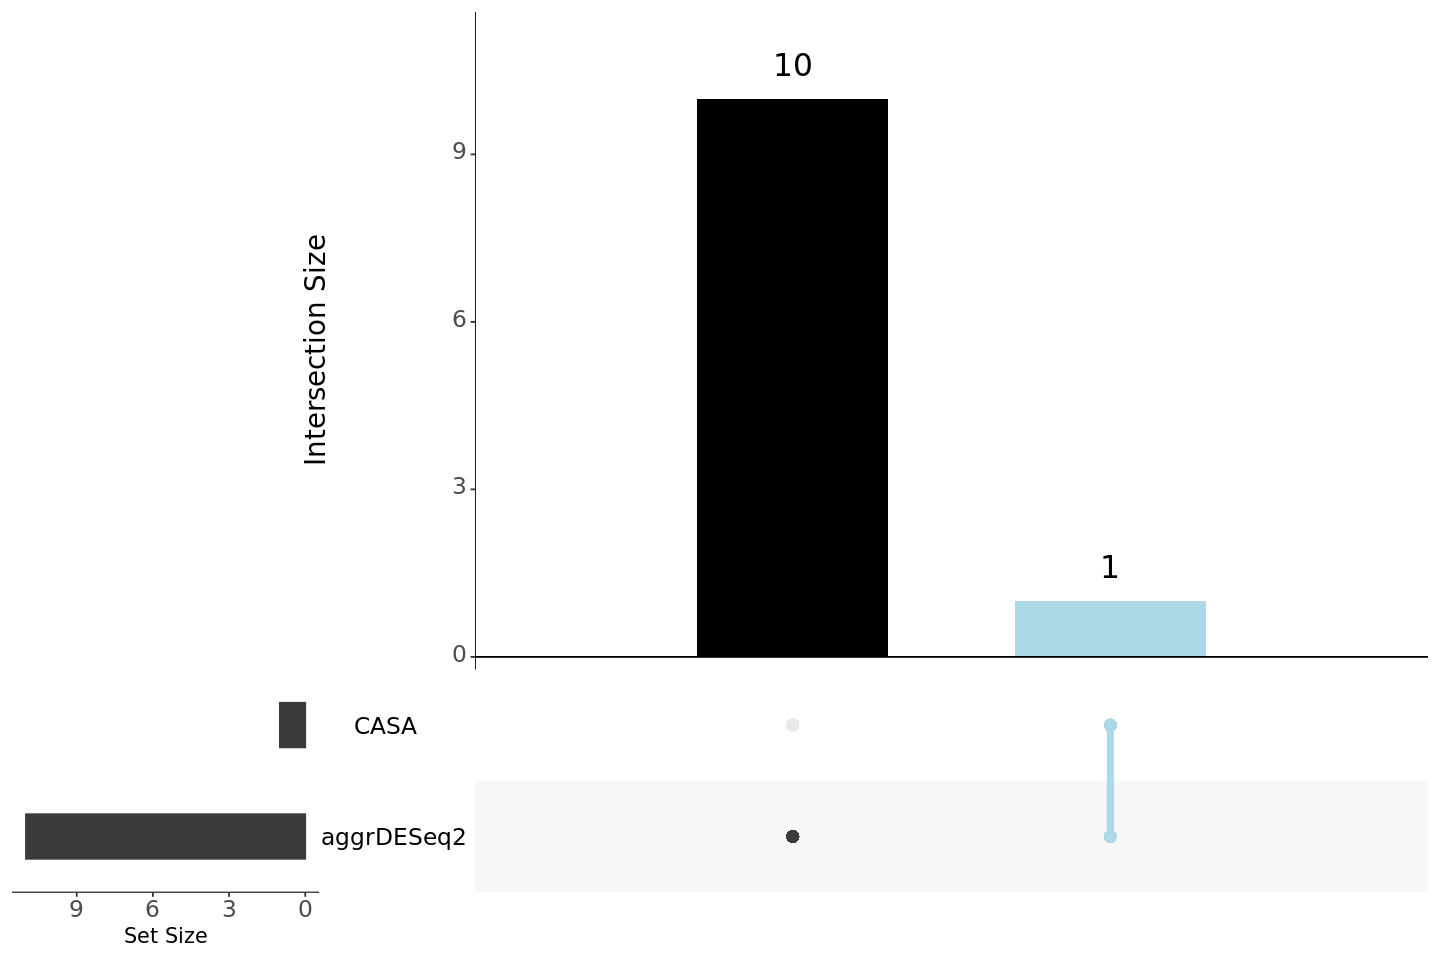

In [20]:
options(repr.plot.width = 12, repr.plot.height = 8)
screen1 <- df %>% filter(casa == 1) %>% select(name) %>% distinct() %>% pull()
screen2 <- df %>% filter(deseq2 == 1) %>% select(name) %>% distinct() %>% pull()

listInput <- list("CASA" = screen1, 
                  "aggrDESeq2" = screen2
                 )

p1 <- upset(fromList(listInput), 
      order.by = "freq",
      nsets = 3,
      queries = list(list(query = intersects, params = list("CASA","aggrDESeq2"), color = "lightblue", active = T)),
      # set_size.show = TRUE, ### these do not look good when added in R, add later in Illustrator
      # set_size.numbers_size = 5,
      point.size = 3.5, 
      line.size = 2, 
      mainbar.y.label = "Intersection Size", 
      sets.x.label = "Set Size", 
      main.bar.color = "black", 
      text.scale = c(2, 2, 1.5, 2, 2, 3) # intersection size title, intersection size tick labels, set size title, set size tick labels, set names, numbers above bars
      ) 

p1

In [21]:
pdf("figure4_tcells/plot_pdfs/gitr_upsetplot_aggrdeseq2_removemostsig_casa.pdf")
print(p1)
dev.off()

png 
  2